# EDSA Movie Recommendation Challenge

# Introduction

## Context

In today’s technology driven world, recommender systems are socially and economically critical for ensuring that individuals can make appropriate choices surrounding the content they engage with on a daily basis. One application where this is especially true surrounds movie content recommendations; where intelligent algorithms can help viewers find great titles from tens of thousands of options.

## Problem Statement
With this context, EDSA is challenging you to construct a recommendation algorithm based on content or collaborative filtering, capable of accurately predicting how a user will rate a movie they have not yet viewed based on their historical preferences.

Providing an accurate and robust solution to this challenge has immense economic potential, with users of the system being exposed to content they would like to view or purchase - generating revenue and platform affinity.

## Evaluation
The evaluation metric for this competition is Root Mean Square Error. Root Mean Square Error (RMSE) is commonly used in regression analysis and forecasting, and measures the standard deviation of the residuals arising between predicted and actual observed values for a modelling process.

# Data Exploration

## Installing and Importing packages


In [ ]:
# !pip install turicreate

In [2]:
import pandas as pd
import numpy as np
import re

# import turicreate

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Data Overview
This dataset consists of several million 5-star ratings obtained from users of the online MovieLens movie recommendation service. The MovieLens dataset has long been used by industry and academic researchers to improve the performance of explicitly-based recommender systems, and now you get to as well!

### Source
The data for the MovieLens dataset is maintained by the GroupLens research group in the Department of Computer Science and Engineering at the University of Minnesota. Additional movie content data was legally scraped from IMDB

### Supplied Files

1. genome_scores.csv - a score mapping the strength between movies and tag-related properties.
2. genome_tags.csv - user assigned tags for genome-related scores
3. imdb_data.csv - Additional movie metadata scraped from IMDB using the links.csv file.
4. movies.csv - consists of userId,movieId,tag and timestamp
5. links.csv - File providing a mapping between a MovieLens ID and associated IMDB and TMDB IDs.
6. tags.csv - User assigned for the movies within the dataset.
7. test.csv - The test split of the dataset. Contains user and movie IDs with no rating data.
8. train.csv - The training split of the dataset. Contains user and movie IDs with associated rating data.

### Loading data files

In [197]:
train_data = pd.read_csv('/content/drive/My Drive/Projects/recommendation_engine/data/train.csv', usecols = ['userId', 'movieId', 'rating'])
test_data = pd.read_csv('/content/drive/My Drive/Projects/recommendation_engine/data/test.csv')
imdb_data = pd.read_csv('/content/drive/My Drive/Projects/recommendation_engine/data/imdb_data.csv')
movies_data = pd.read_csv('/content/drive/My Drive/Projects/recommendation_engine/data/movies.csv')

In [30]:
print(train_data.shape)
train_data.head()

(10000038, 3)


,userId,movieId,rating
0,5163,57669,4.0
1,106343,5,4.5
2,146790,5459,5.0
3,106362,32296,2.0
4,9041,366,3.0


Train data consists of 3 columns (userId, movieId and rating). We dropped the timestamp when we loaded the data. We have 10 million rows in total.

In [31]:
print(imdb_data.shape)
imdb_data.head(3)

(27278, 6)


,movieId,title_cast,director,runtime,budget,plot_keywords
0,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation
1,2,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh,104.0,"$65,000,000",board game|adventurer|fight|game
2,3,Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...,Mark Steven Johnson,101.0,"$25,000,000",boat|lake|neighbor|rivalry


Imdb_data has 5 columns besides the movieId, i.e title_cast, movie director, plot key words, runtime and budget. Has 27278 movieIds, much less than we have in the training data.

In [32]:
print(movies_data.shape)
movies_data.head(3)

(62423, 3)


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance


Movies_data contains a movie's actual title as well as the movie genre. 62423 movies in total indicating that some of the movies in the table are not in train_data.

###### task: merge tables
Below we utilise a pandas function that joins 2 data tables thus the function takes as argument 2 dataframes, joins them by a column. Note that the joining operation can be done on columns such as userId or movieId. First we'll merge imdb_data and movies_data as these tables contain information thats directly related to each other by movieId. We call the new table items_data, referencing movies as items. Note also that we do an outer join. This is so we can preserve all movieIds. Later we'll drop movieIds that are not available in the training data. The resulting table will have 64835 movies in total and 6 columns as displayed below.

In [33]:
items_data = pd.merge(
    left = imdb_data,
    right = movies_data,
    on = ['movieId'],
    how = 'outer'
)

print(items_data.shape)
items_data.head(3)

(64835, 8)


,movieId,title_cast,director,runtime,budget,plot_keywords,title,genres
0,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh,104.0,"$65,000,000",board game|adventurer|fight|game,Jumanji (1995),Adventure|Children|Fantasy
2,3,Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...,Mark Steven Johnson,101.0,"$25,000,000",boat|lake|neighbor|rivalry,Grumpier Old Men (1995),Comedy|Romance


The next step is to drop movie items in items_data that are not available in train_data. To determine if a movie item is present in train_data, we'll do yet another merge operation. This time we merge the table items_data with only the movieId column of train_data. This we do for computational and storage reasons as the merge will result in many duplicate rows for each userId in train_data. We'll also set the how parameter of the merge function to left to prioritise observation in train_data and drop those that are not. Further, instead of immediately storing the merged table, we'll first drop duplicates in it so that we dont have duplicated information about movie items. 

In [34]:
items_data = pd.merge(left = train_data[['movieId']], right = items_data, ).drop_duplicates()
print(items_data.shape)
items_data.head(3)

(48213, 8)


,movieId,title_cast,director,runtime,budget,plot_keywords,title,genres
0,57669,Elizabeth Berrington|Rudy Blomme|Olivier Bonjo...,Martin McDonagh,107.0,"$15,000,000",dwarf|bruges|irish|hitman,In Bruges (2008),Comedy|Crime|Drama|Thriller
4253,5,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,106.0,"$30,000,000",fatherhood|doberman|dog|mansion,Father of the Bride Part II (1995),Comedy
8901,5459,Tommy Lee Jones|Will Smith|Rip Torn|Lara Flynn...,Lowell Cunningham,88.0,"$140,000,000",lingerie|michael jackson character|shorthaired...,Men in Black II (a.k.a. MIIB) (a.k.a. MIB 2) (...,Action|Comedy|Sci-Fi


The result is items_data with only 48213 rows and 8 columns. Does train_data have 48213 movieIds? Lets check.

In [35]:
train_data['movieId'].nunique()

48213

###### task: investigate missing entries

In [36]:
train_data.isna().sum()

userId     0
movieId    0
rating     0
dtype: int64

train_data has zero missing entires.

In [37]:
items_data.isna().sum() / items_data.shape[0]

movieId          0.000000
title_cast       0.697799
director         0.695435
runtime          0.729865
budget           0.852094
plot_keywords    0.711572
title            0.000000
genres           0.000000
dtype: float64

items_data has a significant amount of missing entries, between 69% and 85% across the columns. Mostly missing are the movie budgets. This indicates that we ought to be careful interms of the conclusions we draw from this movie contents table. To be able to analyse the textual data in these columns however, we need to treat them. Similarly, for the budget and runtime columns. How do we treat them? ...

In [38]:
# items_data.fillna(' ', inplace = True)

###### task: cleaning up the text data
In this task we take the opportunity to do further cleaning of the text content of movie items. How do we clean the text? ...

In [28]:
items_data.head(3)

,movieId,title_cast,director,plot_keywords,title,genres
0,57669,Elizabeth Berrington|Rudy Blomme|Olivier Bonjo...,Martin McDonagh,dwarf|bruges|irish|hitman,In Bruges (2008),Comedy|Crime|Drama|Thriller
4253,5,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,fatherhood|doberman|dog|mansion,Father of the Bride Part II (1995),Comedy
8901,5459,Tommy Lee Jones|Will Smith|Rip Torn|Lara Flynn...,Lowell Cunningham,lingerie|michael jackson character|shorthaired...,Men in Black II (a.k.a. MIIB) (a.k.a. MIB 2) (...,Action|Comedy|Sci-Fi


In [ ]:
# text_corpus = [row[2].replace(' ', '_').replace('|', ' ') + ' ' + row[3].replace('|', ' ') + ' ' + row[4].replace(' ', '_').replace('|', ' ') + ' ' + row[6].replace(' ', '_').replace('|', ' ') for row in item_data.itertuples()]

In [ ]:
# item_data['text'] = pd.Series(text_corpus)

# del text_corpus, imdb_data, movies_data
# item_data.drop(['title_cast', 'director', 'plot_keywords', 'title', 'genres'], axis = 1, inplace = True)

# item_data.head(3)

,movieId,text
0,57669,Elizabeth_Berrington Rudy_Blomme Olivier_Bonjo...
1,5,Steve_Martin Diane_Keaton Martin_Short Kimberl...
2,5459,Tommy_Lee_Jones Will_Smith Rip_Torn Lara_Flynn...


In [ ]:
# def cleanText(text):
#     new_text = text.replace('_', '')
#     return new_text

# item_data['text'] = item_data['text'].map(cleanText)

# item_data.head(3)

,movieId,text
0,57669,ElizabethBerrington RudyBlomme OlivierBonjour ...
1,5,SteveMartin DianeKeaton MartinShort KimberlyWi...
2,5459,TommyLeeJones WillSmith RipTorn LaraFlynnBoyle...


# Exploratory Data Analysis Part One

In [39]:
n_users = train_data['userId'].nunique()
n_items = train_data['movieId'].nunique()

print('Number of Users: '+ str(n_users))
print('Number of Movies: '+str(n_items))

Number of Users: 162541
Number of Movies: 48213


In [40]:
train_data.head()

,userId,movieId,rating
0,5163,57669,4.0
1,106343,5,4.5
2,146790,5459,5.0
3,106362,32296,2.0
4,9041,366,3.0


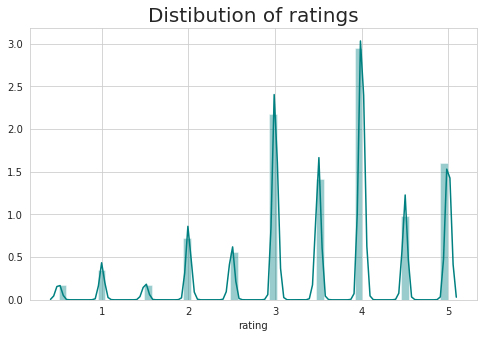

In [52]:
plt.figure(figsize = (8, 5))
g = sns.distplot(train_data['rating'], color = 'teal')
g.set_title('Distibution of ratings', fontsize = 20)
plt.show()

In [112]:
num_of_movies_watched = train_data.groupby('userId')['movieId'].count().sort_values(ascending = False)
num_of_movies_watched

userId
72315     12952
80974      3680
137293     3588
33844      3208
20055      3050
          ...  
55362         1
121071        1
127098        1
53640         1
105714        1
Name: movieId, Length: 162541, dtype: int64

In [142]:
more_than_200 = num_of_movies_watched > 200
userids_w_more_than_200 = num_of_movies_watched[more_than_200].index
print(f"Only {len(userids_w_more_than_200)} users have watched more than 200 movies in the dataset.")

Only 9677 users have watched more than 200 movies in the dataset.


In [210]:
less_than_5 = num_of_movies_watched < 5
userids_w_less_than_5 = num_of_movies_watched[less_than_5].index
print(f"{len(userids_w_less_than_5)} users have watched less than 5 movies in the dataset.")

618 users have watched less than 5 movies in the dataset.


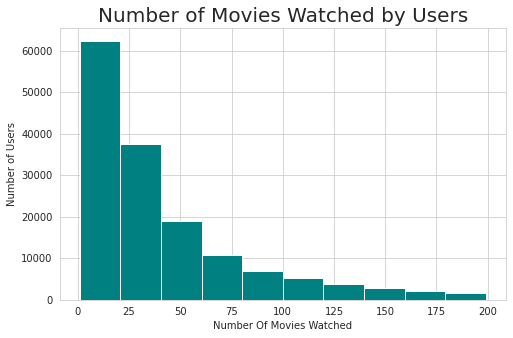

In [211]:
fig = plt.figure(figsize = (8, 5))
less_than_200 = num_of_movies_watched < 200
g = num_of_movies_watched[less_than_200].plot(kind = 'hist', color = 'teal')
# g.set_ylim(0, 10)
g.set_xlabel('Number Of Movies Watched')
g.set_ylabel('Number of Users')
g.set_title('Number of Movies Watched by Users', fontsize = 20)
plt.show()

The Top users account for approximately 35.8% of the samples in train_data 



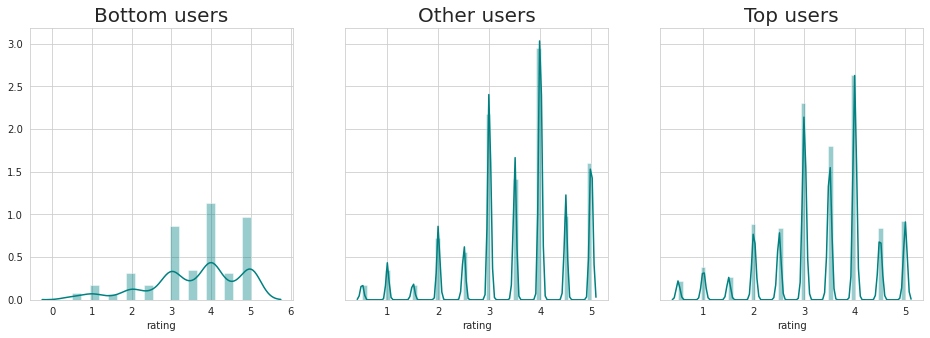

In [212]:
top_users_mask = train_data['userId'].isin(userids_w_more_than_200)
bottom_users_mask = train_data['userId'].isin(userids_w_less_than_5)

print(f"The Top users account for approximately {round(top_users_mask.sum() / len(train_data) * 100, 2)}% of the samples in train_data \n")

fig, axes = plt.subplots(1, 3, figsize = (16, 5), sharey = True)

g = sns.distplot(train_data[top_users_mask]['rating'], color = 'teal', ax = axes[2])
g.set_title('Top users', fontsize = 20)

g = sns.distplot(train_data[~(top_users_mask & bottom_users_mask)]['rating'], color = 'teal', ax = axes[1])
g.set_title('Other users', fontsize = 20)

g = sns.distplot(train_data[bottom_users_mask]['rating'], color = 'teal', ax = axes[0])
g.set_title('Bottom users', fontsize = 20)

plt.show()

In [213]:
avg_rating = train_data.groupby('userId')[['rating']].mean().rename(columns = {'rating':'user_avg_rating'})
user_movie_count = pd.DataFrame(num_of_movies_watched).rename(columns = {'movieId':'user_movie_count'})
users_data = pd.concat([avg_rating, user_movie_count], axis = 1).reset_index()

users_data.head()

,userId,user_avg_rating,user_movie_count
0,1,3.910714,28
1,2,3.416667,72
2,3,3.691235,251
3,4,3.308989,89
4,5,3.885714,35


<Figure size 576x360 with 0 Axes>

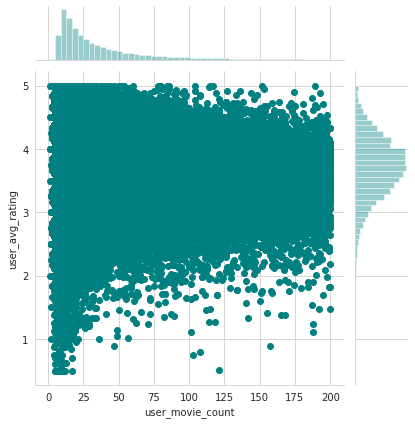

In [214]:
mask = users_data['userId'].isin(userids_w_more_than_200)

fig = plt.figure(figsize = (8, 5))
sns.jointplot(data = users_data[~mask], x = 'user_movie_count', y = 'user_avg_rating', color = 'teal')
# plt.title('Relationship between ratings and number of movies watched \n\n\n\n', fontsize = 20)
# plt.xlabel('Number of movies watched \n', fontsize = 20)
plt.show()